In [14]:
pip install urlextract



   ---------------------------------------- 2/2 [urlextract]

Note: you may need to restart the kernel to use updated packages.


In [15]:
import pandas as pd
import numpy as np
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import emoji
from urlextract import URLExtract

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

extract = URLExtract()

In [16]:
def preprocess(data):
    pattern = r'\d{1,2}/\d{1,2}/\d{2},\s\d{1,2}:\d{2}\u202f[ap]m\s-\s'

    messages = re.split(pattern, data)[1:]
    dates = re.findall(pattern, data)

    df = pd.DataFrame({'user_message': messages, 'message_date': dates})
    df['message_date'] = df['message_date'].str.replace('\u202f',' ', regex=False)
    df['message_date'] = pd.to_datetime(
        df['message_date'],
        format='%d/%m/%y, %I:%M %p - ',
        errors='coerce'
    )

    df.rename(columns={'message_date': 'date'}, inplace=True)

    users = []
    messages_clean = []

    for message in df['user_message']:
        entry = re.split(r'([\w\W]+?):\s', message)
        if entry[1:]:
            users.append(entry[1])
            messages_clean.append(" ".join(entry[2:]))
        else:
            users.append('group_notification')
            messages_clean.append(entry[0])

    df['user'] = users
    df['message'] = messages_clean
    df.drop(columns=['user_message'], inplace=True)

    return df

In [17]:
with open("chat.txt", "r", encoding="utf-8") as f:
    data = f.read()

df = preprocess(data)

print("Total Messages:", df.shape[0])
print("Total Users:", df['user'].nunique())

df.head()

Total Messages: 11139
Total Users: 4


,date,user,message
0,2025-01-12 20:52:00,group_notification,Messages and calls are end-to-end encrypted. O...
1,2023-01-20 21:42:00,group_notification,"Neha Vengurlekar created group ""Sabka Sath Sab..."
2,2023-01-20 21:42:00,group_notification,You were added\n
3,2025-01-14 00:08:00,Anjali A,Happiest Mankar Sankranti mere pyare dosto\n
4,2025-01-14 10:56:00,Shashi,खिचड़ी की हार्दिक शुभकामनाएँ 🙏\n


In [18]:
df = df.dropna(subset=['date'])
df = df[df['user'] != 'group_notification']
df = df[df['message'] != '<Media omitted>\n']
df = df[['date','message','user']]

In [19]:
num_messages = df.shape[0]

words = []
for msg in df['message']:
    words.extend(msg.split())

num_media = df[df['message'] == '<Media omitted>\n'].shape[0]

links = []
for msg in df['message']:
    links.extend(extract.find_urls(msg))

print("Total Messages:", num_messages)
print("Total Words:", len(words))
print("Media Messages:", num_media)
print("Links Shared:", len(links))

Total Messages: 10408
Total Words: 53599
Media Messages: 0
Links Shared: 64


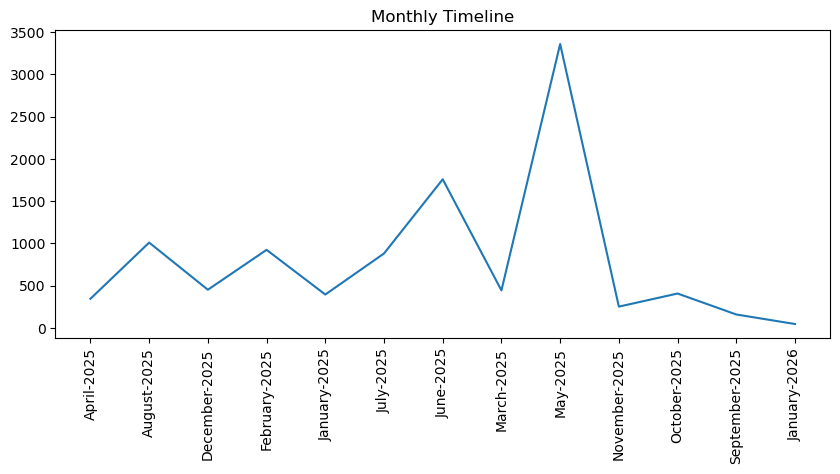

In [20]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name()

timeline = df.groupby(['year','month']).count()['message'].reset_index()

time = []
for i in range(timeline.shape[0]):
    time.append(timeline['month'][i] + "-" + str(timeline['year'][i]))

timeline['time'] = time

plt.figure(figsize=(10,4))
plt.plot(timeline['time'], timeline['message'])
plt.xticks(rotation=90)
plt.title("Monthly Timeline")
plt.show()

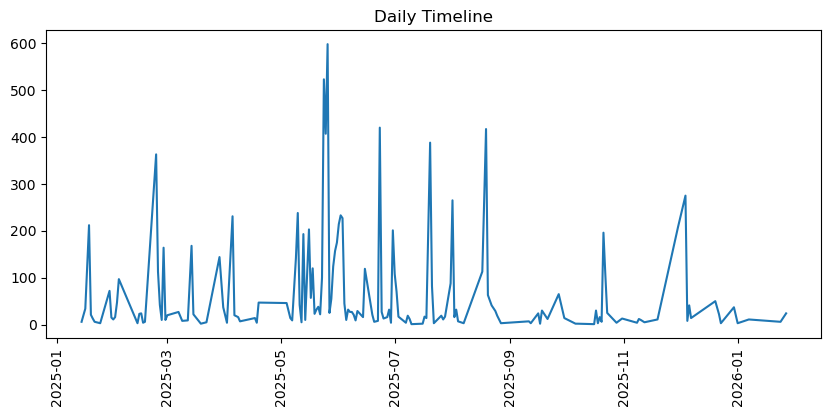

In [21]:
df['only_date'] = df['date'].dt.date
daily = df.groupby('only_date').count()['message'].reset_index()

plt.figure(figsize=(10,4))
plt.plot(daily['only_date'], daily['message'])
plt.xticks(rotation=90)
plt.title("Daily Timeline")
plt.show()

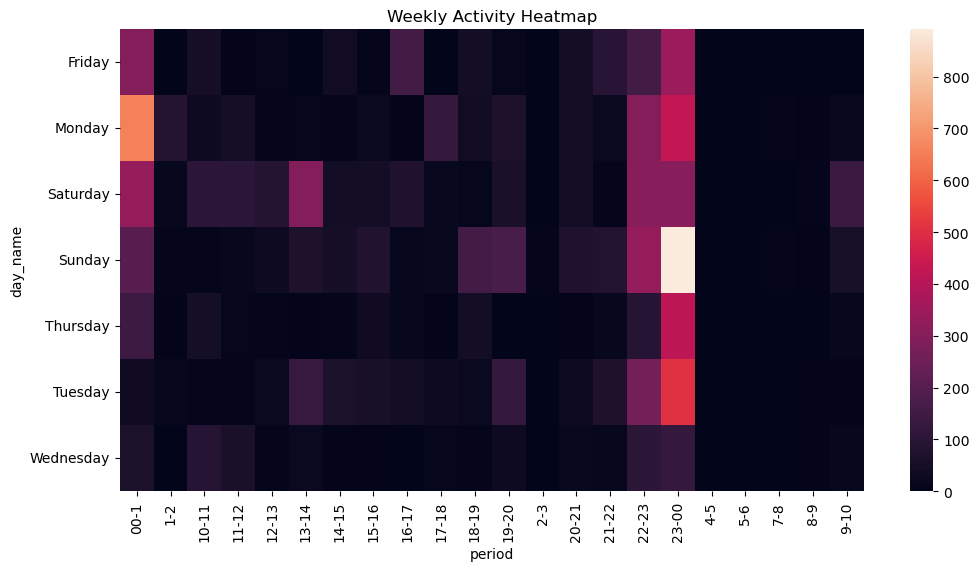

In [22]:
df['day_name'] = df['date'].dt.day_name()
df['hour'] = df['date'].dt.hour

period = []
for h in df['hour']:
    if h == 23:
        period.append("23-00")
    elif h == 0:
        period.append("00-1")
    else:
        period.append(f"{h}-{h+1}")

df['period'] = period

heatmap = df.pivot_table(
    index='day_name',
    columns='period',
    values='message',
    aggfunc='count'
).fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap)
plt.title("Weekly Activity Heatmap")
plt.show()

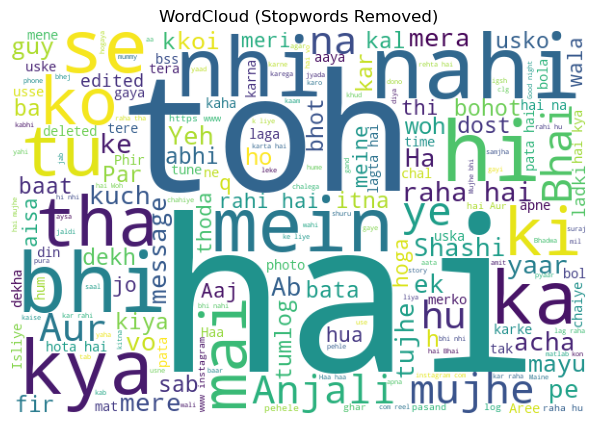

In [23]:
wc = WordCloud(
    width=600,
    height=400,
    background_color='white',
    stopwords=ENGLISH_STOP_WORDS
)

wc_img = wc.generate(df['message'].str.cat(sep=" "))

plt.figure(figsize=(8,5))
plt.imshow(wc_img)
plt.axis("off")
plt.title("WordCloud (Stopwords Removed)")
plt.show()

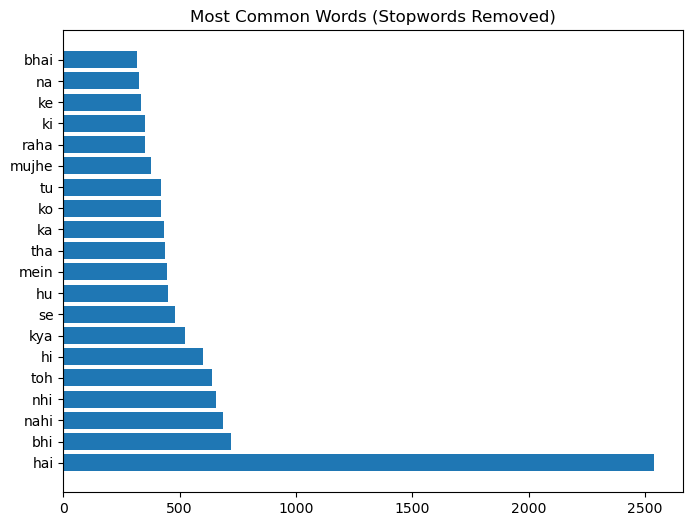

In [24]:
all_words = []

for msg in df['message']:
    for w in msg.lower().split():
        w = re.sub(r'[^\w\s]', '', w)
        if w not in ENGLISH_STOP_WORDS and w.strip() != '':
            all_words.append(w)

common_df = pd.DataFrame(Counter(all_words).most_common(20))

plt.figure(figsize=(8,6))
plt.barh(common_df[0], common_df[1])
plt.title("Most Common Words (Stopwords Removed)")
plt.show()

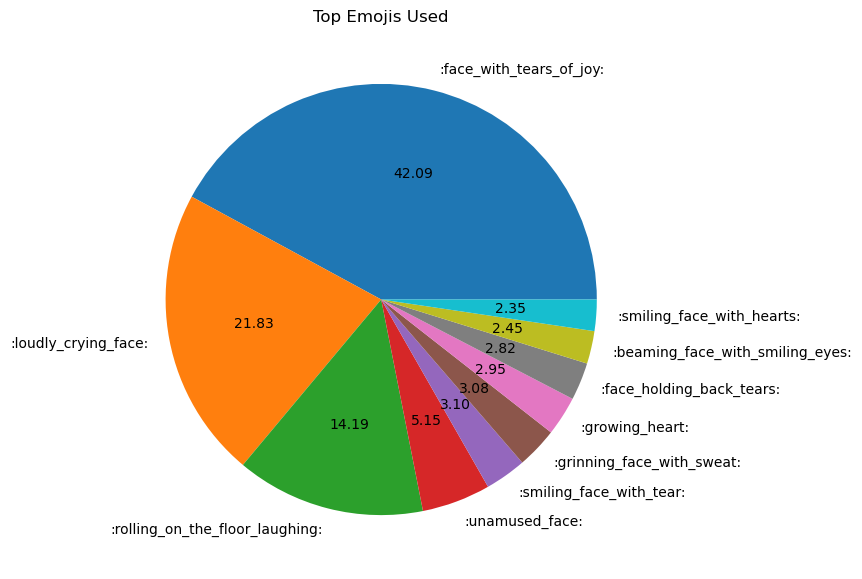

In [25]:
import emoji
from collections import Counter

emojis = []
for msg in df['message']:
    emojis.extend([c for c in msg if c in emoji.EMOJI_DATA])

emoji_df = pd.DataFrame(Counter(emojis).most_common(10))
emoji_df['label'] = emoji_df[0].apply(lambda x: emoji.EMOJI_DATA[x]['en'])

plt.figure(figsize=(7,7))
plt.pie(emoji_df[1], labels=emoji_df['label'], autopct="%0.2f")
plt.title("Top Emojis Used")
plt.show()

In [26]:
df_ml = df[['message','user']]

user_counts = df_ml['user'].value_counts()
valid_users = user_counts[user_counts >= 2].index
df_ml = df_ml[df_ml['user'].isin(valid_users)]

X = df_ml['message']
y = df_ml['user']

print("Messages for ML:", X.shape[0])
print("Users for ML:", y.nunique())

Messages for ML: 10408
Users for ML: 3


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [29]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [30]:
y_pred = model.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))

Accuracy: 0.6829971181556196

Classification Report:

              precision    recall  f1-score   support

    Anjali A       0.67      0.90      0.77       960
    Mayuresh       0.77      0.51      0.61       516
      Shashi       0.67      0.48      0.56       606

    accuracy                           0.68      2082
   macro avg       0.70      0.63      0.65      2082
weighted avg       0.69      0.68      0.67      2082



In [31]:
sample = ["Are you coming to college tomorrow?"]
sample_vec = vectorizer.transform(sample)

print("Predicted User:", model.predict(sample_vec)[0])

Predicted User: Shashi
